<h1>Definitions</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import IBMQ, Aer,QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import cvxpy
import mitiq

In [2]:
def noisem(prob_2q):
    #Create noise model
    noisemodel = NoiseModel()
    #Define times and probabilities
    prob_1q = 1-0.9969
    # prob_2q = 1-0.9773
    time_t1 = 10000*1e9
    time_t2 = 0.2*1e9
    time_1q = 0.00001*1e9
    time_2q = 0.0002*1e9
    time_measure = 0.00013*1e9
    time_reset = 0.00002*1e9
    #Define errors
    # error_reset = thermal_relaxation_error(time_t1, time_t2, time_reset)
    # error_meas = thermal_relaxation_error(time_t1, time_t2, time_measure)
    # error_1q  = thermal_relaxation_error(time_t1, time_t2, time_1q)
    # error_2q = thermal_relaxation_error(time_t1, time_t2, time_2q).expand(
    #              thermal_relaxation_error(time_t1, time_t2, time_2q))
    error_1 = depolarizing_error(prob_1q, 1)
    error_2 = depolarizing_error(prob_2q, 2)
    #Add errors to noise model
    # noisemodel.add_all_qubit_quantum_error(error_reset, "reset")
    # noisemodel.add_all_qubit_quantum_error(error_meas, "measure")
    # noisemodel.add_all_qubit_quantum_error(error_1q, ['h','rz'])
    # noisemodel.add_all_qubit_quantum_error(error_2q, ['cx'])
    noisemodel.add_all_qubit_quantum_error(error_1, ['h', 'rz'])
    noisemodel.add_all_qubit_quantum_error(error_2, ['cx'])
    basis_gates = noisemodel.basis_gates

    return noisemodel, basis_gates

In [3]:
# # Get basis gates from noise model
# basis_gates = noisemodel.basis_gates
# print(noisemodel)

In [4]:
def wrapper(noisemodel, basis_gates, circlogic,noisy_or_perfect,do_not_plot='false', **kwargs):
    if noisy_or_perfect=='perfect':
        return circlogic(None,None,do_not_plot,**kwargs)
    elif noisy_or_perfect=='noisy':
        return circlogic(basis_gates,noisemodel,do_not_plot,**kwargs)
    else:
        print('Wrong argument to noisy_or_perfect')

<h1>Collisional model</h1>

<h2>Correlated case</h2>

In [5]:
def corr(q, c, system, ancillae, g, t, i):
    coA = QuantumCircuit(q,c)
    
    # State Preparation
    coA.h(q[system])
    coA.h(q[ancillae[2]])
    coA.cnot(q[ancillae[2]],q[ancillae[1]])
    coA.cnot(q[ancillae[2]],q[ancillae[0]])
    
    # Collisions between the system and ancilla qubits
    for j in range(1, i+1, 1):
        if j%2 != 0:
            coA.cnot(q[ancillae[0]],q[system])
            coA.rz(t, q[system])
            coA.cnot(q[ancillae[0]],q[system])
        else:
            coA.cnot(q[ancillae[1]],q[system])
            coA.rz(t, q[system])
            coA.cnot(q[ancillae[1]],q[system])
    
    coA.h(q[system])
    # op = qi.Operator(coA)
    # array = op.data
    # print(array)
    
    coA.measure(q[system],c[0])
        
    # return coA, array
    return coA

In [6]:
def circ_correlate(basis_gates,noise_model,do_not_plot,**kwargs):
    q = QuantumRegister(4,name = 'q')
    c = ClassicalRegister(1, name = 'c')
    system = 0
    ancillae = [1, 2, 3]
    rho_12, T = [], []
    n = kwargs.get('collisions')
    tt = np.pi/6
    g = 1
    t = g*(tt)
    numcx = []
    gatedepth = []
    pf = []
    def corrfunc(time):
        return (np.cos(time/2)**2-np.sin(time/2)**2)/2
    for i in range(1,n+1,1):
        circ = corr(q, c, system, ancillae, g, tt, i)
        numcx.append(circ.count_ops()['cx'])
        gatedepth.append(circ.depth())
        T.append(i*t)
        pf.append(corrfunc(i*t))
        job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
        counts = job.result().get_counts()  
        rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))

    abserr = [abs(rho_12[i]-pf[i]) for i in range(len(numcx))]

    x_ax = np.linspace(0,T[-1],num=1000)
    if do_not_plot=='false':
        plt.scatter(T, np.real(rho_12),label='Simulation')
        plt.title(kwargs.get('plot_title'))
        plt.plot(x_ax,corrfunc(x_ax),linestyle='--',label='Theoretical')
        plt.legend()
        plt.show()
    return numcx,gatedepth,abserr, rho_12,pf

In [12]:
from mitiq.zne import execute_with_zne
from mitiq import zne
def corr_circ(basis_gates,noise_model,do_not_plot,**kwargs):
    q = QuantumRegister(4,name = 'q')
    c = ClassicalRegister(1, name = 'c')
    system = 0
    ancillae = [1, 2, 3]
    rho_12, T = [], []
    n = kwargs.get('collisions')
    tt = np.pi/6
    g = 1
    t = g*(tt)
    numcx = []
    gatedepth = []
    znee = []
    for i in range(1,n+1,1):
        circ = corr(q, c, system, ancillae, g, tt, i)
        numcx.append(circ.count_ops()['cx'])
        gatedepth.append(circ.depth())
        T.append(i*t)
        def executor ( circ : mitiq.QPROGRAM) -> float:
            #circ2 = corr(q, c, system, ancillae, g, tt, i)
            job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
            counts = job.result().get_counts() 
            return (counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0)))
        
        zne_value = execute_with_zne (circ, 
                              executor, 
                              scale_noise=zne.scaling.fold_global)
        znee.append(zne_value)
    return T,znee

In [17]:
# Mitigated
noisemodel, basis_gates = noisem(1-0.9773)
T,znee = wrapper(noisemodel, basis_gates, corr_circ,'perfect','true',shots=512,collisions=20)
print('*****')
print(znee)
print(len(znee))

*****
[0.5117187499999994, 0.20117187499999975, -0.07617187500000025, -0.2675781249999999, -0.34960937499999956, -0.49999999999999883, -0.4101562499999999, -0.2890624999999996, 0.06640625000000004, 0.10351562499999946, 0.38085937499999933, 0.49999999999999883, 0.4785156250000001, 0.23046875, 0.019531250000000076, -0.22851562499999947, -0.4179687499999997, -0.49999999999999883, -0.39453124999999956, -0.17578124999999975]
20


In [18]:
# Noise - Unmitigated
noisemodel, basis_gates = noisem(1-0.9773)
numcx,gatedepth,abserr, rho12,pf = wrapper(noisemodel, basis_gates, circ_correlate,'noisy','true',shots=512,collisions=20)
print('*****')
print(rho12)
print(len(rho12))

*****
[0.40625, 0.263671875, 0.046875, -0.220703125, -0.33984375, -0.333984375, -0.3203125, -0.169921875, -0.017578125, 0.185546875, 0.2421875, 0.255859375, 0.220703125, 0.15234375, -0.00390625, -0.103515625, -0.185546875, -0.13671875, -0.20703125, -0.111328125]
20


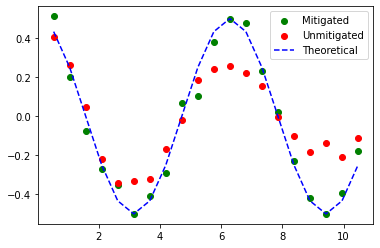

In [19]:
#print(len(T))
#print(len(znee))
#print(len(rho12))
plt.scatter(T,znee,c='green',label='Mitigated')
plt.scatter(T,rho12,c='red',label='Unmitigated')
plt.plot(T,pf,c='blue',linestyle='--',label='Theoretical')
plt.legend()
plt.show()

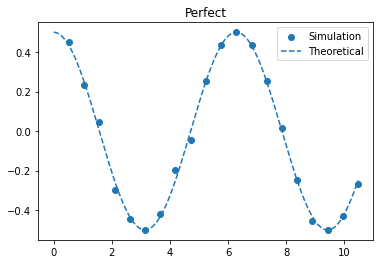

*****
[0.44921875, 0.234375, 0.046875, -0.296875, -0.4453125, -0.5, -0.41796875, -0.1953125, -0.04296875, 0.25390625, 0.4375, 0.5, 0.4375, 0.25390625, 0.015625, -0.24609375, -0.453125, -0.5, -0.4296875, -0.26953125]
20


In [21]:
# No noise
noisemodel, basis_gates = noisem(1-0.9773)
numcx,gatedepth,abserr, znee, pf = wrapper(None, None, circ_correlate,'perfect',plot_title='Perfect',shots=256,collisions=20)
print('*****')
print(znee)
print(len(znee))

In [ ]:
numcx,gatedepth,abserr, znee = wrapper(None, None, circ_correlate,'perfect',plot_title='Perfect',shots=256,collisions=20)

In [ ]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    numcx,gatedepth,abserr, znee = wrapper(noisemodel, basis_gates, circ_correlate,'noisy',plot_title=f'Noisy (fidelity={np.around(1-i,4)})',shots=256,collisions=20)

In [ ]:
plt.plot(numcx,abserr,c='red')
plt.scatter(numcx,abserr)
plt.xlabel('Number of CNOT gates')
plt.ylabel('Absolute error')
plt.show()

In [ ]:
plt.plot(numcx,gatedepth,c='red')
plt.scatter(numcx,gatedepth)
plt.xlabel('Number of CNOT gates')
plt.ylabel('gatedepth')
plt.show()

In [ ]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates, circ_correlate,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=20)[2]) for shots in shotsnum]

In [ ]:
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')

<h2>Uncorrelated case</h2>

In [ ]:
def uncorr(q, c, system, ancillae, g, t, i):
    ucoA = QuantumCircuit(q,c)
    ucoA.h(q[system])
    # State Preparation
    for l in range(i):
        ucoA.h(q[ancillae[l]])
    
    # Collisions between the system and ancilla qubits
    for j in range(1,i+1):
        ucoA.cnot(q[j],q[system])
        ucoA.rz(t, q[system])
        ucoA.cnot(q[j],q[system])
    
    ucoA.h(q[system])
    
    ucoA.measure(q[system],c[0])
        
    return ucoA

In [ ]:
def circ_uncorrelate(basis_gates,noise_model,do_not_plot,**kwargs):
    n = kwargs.get('collisions')
    q = QuantumRegister(n+1,name = 'q')
    c = ClassicalRegister(1, name = 'c')
    system = 0
    ancillae = range(1,n+1)
    rho_12, T = [], []
    tt = np.pi/6
    g = 1
    t = g*(tt)
    numcx = []
    gatedepth = []
    for i in range(1,n+1,1):
        circ = uncorr(q, c, system, ancillae, g, 2*tt, i)
        numcx.append(circ.count_ops()['cx'])
        gatedepth.append(circ.depth())
        T.append(i*t)
        job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
        counts = job.result().get_counts()   
        rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))

        
    def uncorrfunc(i):
        return np.power(np.cos(2*g*tt),i/t)/2
    
    abserr = [abs(rho_12[i]-uncorrfunc(T[i])) for i in range(len(numcx))]

    x_ax = np.linspace(0,T[-1],num=1000)
    if do_not_plot=='false':
        plt.title(kwargs.get('plot_title'))
        plt.scatter(T, np.real(rho_12),label='Simulation')
        plt.plot(x_ax,uncorrfunc(x_ax),linestyle='--',label='Theoretical')
        #plt.scatter(T, rho_12)
        plt.legend()
        plt.show()
    return numcx,gatedepth,abserr

In [ ]:
numcx,gatedepth,abserr = wrapper(None, None, circ_uncorrelate,'perfect',plot_title='Perfect',shots=1024,collisions=7)

In [ ]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    numcx,gatedepth,abserr = wrapper(noisemodel, basis_gates, circ_uncorrelate,'noisy',plot_title=f'Noisy (fidelity={np.around(1-i,4)})',shots=1024,collisions=7)

In [ ]:
plt.plot(numcx,abserr,c='red')
plt.scatter(numcx,abserr)
plt.xlabel('Number of CNOT gates')
plt.ylabel('Absolute error')
plt.show()

In [ ]:
plt.plot(numcx,gatedepth,c='red')
plt.scatter(numcx,gatedepth)
plt.xlabel('Number of CNOT gates')
plt.ylabel('gatedepth')
plt.show()

In [ ]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates,circ_uncorrelate,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=7)[2]) for shots in shotsnum]

In [ ]:
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')
plt.xlabel('Number of shots')
plt.ylabel('Mean Error for a particular number of shots')
plt.show()